### Setup

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from pyfunctions import LHC_score, get_la

2024-02-21 14:08:13.972397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 14:08:14.185774: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-21 14:08:14.192128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/casper/23.10/spack/opt/spack/openmpi/4.1.6/oneapi/2023.2.1/dgcv/lib:/glade/u/apps/

In [2]:
# load LHC PPE parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
lhc_params = df.drop(columns='member')
num_params = len(lhc_params.columns)
pb_index = np.load('pb_index.npy',allow_pickle='TRUE').item()
pb_priority = np.load('pb_priority.npy',allow_pickle='TRUE').item()


In [3]:
whit=xr.open_dataset('whit/whitkey.nc')
biome_names = whit.biome_name.values
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pft_names=[str(p)[2:-1].strip() for p in pfts.values]

In [4]:
out_dir = '/glade/work/linnia/CLM-PPE-LAI_tests/wave1/'

In [5]:
pft_params   = ['froot_leaf','kmax','krmax','leaf_long','leafcn','lmr_intercept_atkin',
                'medlynslope','medlynintercept','psi50','slatop','stem_leaf','theta_cj']
pftix=np.array([p in pft_params for p in lhc_params])

pftparam_id = [lhc_params.columns.get_loc(col) for col in pft_params]
u_params = lhc_params.columns.difference(pft_params)
uparam_id = [lhc_params.columns.get_loc(col) for col in u_params]

In [6]:
n_usamp = 100
n_psamp = 1000

### Screen for GPP

In [7]:
nbiomes = 10
npfts = 17
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14,15]
biome_ids = [1,3,5,6,7,8]

In [8]:
GPP = pd.read_csv("FLUXCOM-GSWP3_GPP_amean_bmean_2001-2010.csv")
GPP_var = pd.read_csv("FLUXCOM_GPP_amean_bmean_variance.csv")
bp_index = np.load('bp_index.npy', allow_pickle=True).item()

In [9]:
# function to calculate total Biome GPP from PFT contributions
f='/glade/work/djk2120/ppe_savs/pbmean/sg_lapxb.nc'
lapxb=xr.open_dataset(f).lapxb
ix=(lapxb.pxb>9)&(lapxb.mean(dim='year').sum(dim='pft')>0)
pxb_la = lapxb.isel(pxb=ix).sum(dim='pft')
pb_la = pxb_la.sel(year=slice(2001,2010)).mean(dim='year').compute()

whitt = xr.open_dataset('../whit/whitkey.nc')
la = get_la()
biome_la = la.groupby(whitt.biome).sum()

In [10]:
# load sample
# Get the plausible samples
file_list = glob(os.path.join(out_dir, 'selected', 'PxB_LAI_NROYsets_*'))
file_list = sorted(file_list)

for i,file_name in enumerate(file_list):
    if i==0:
        Psample = np.load(file_name)
    else:
        sample = np.load(file_name)
        Psample = np.concatenate((Psample,sample),axis=0)

In [11]:
np.shape(Psample)

(8198, 32, 17)

In [12]:
#############################################
# Calculate implausibility GPP
nPsample = np.shape(Psample)[0]
set_I = np.empty((nPsample,nbiomes))*np.NaN

pred = np.empty((nPsample,npfts,nbiomes))*np.NaN
pred_var = np.empty((nPsample,npfts,nbiomes))*np.NaN

#I_tmp = np.empty((n_usamp,n_psamp,nbiomes))*np.NaN

for b in biome_ids:
    o = GPP.GPP[b]
    ovar = GPP_var.GPP[b]
    
    for i,p in enumerate(bp_index[biome_names[b]]):  
        pxb = p*10+b
        la_p = pb_la.sel(pxb=pxb).values

        sample = Psample[:,:,p]
        
        loaded_emulator = tf.saved_model.load('/glade/u/home/linnia/clm5ppe/pyth/wave1/models_gpp/pft'+str(p)+'_biome'+str(b))
        y, y_var = loaded_emulator.predict(sample)
        
        pred[:,p,b] = y.numpy().flatten()
        pred_var[:,p,b] = y_var.numpy().flatten()

        if (i ==0):
            y_pred_all = la_p*y.numpy().flatten()
            y_pred_var_all = la_p*y_var.numpy().flatten()

        else:
            y_pred_all = np.column_stack((y_pred_all,la_p*y.numpy().flatten()))
            y_pred_var_all = np.column_stack((y_pred_var_all,la_p*y_var.numpy().flatten()))

    y_pred_biome = np.sum(y_pred_all,axis=1)*(1/biome_la[b].values)
    y_pred_var_biome = np.sum(y_pred_var_all,axis=1)*(1/biome_la[b].values)
        
    I = np.abs(o-y_pred_biome) / np.sqrt(ovar + y_pred_var_biome)
    set_I[:,b] = I

2024-02-21 14:09:35.855984: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-21 14:09:35.856051: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc35): /proc/driver/nvidia/version does not exist
2024-02-21 14:09:35.856655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# check if plausible
ix = set_I.copy()
ix[ix<3] = 1
ix[ix>=3] = 0
GPP_I = np.nanmean(ix,axis=1)
ix_plausible_GPP = np.where(GPP_I==1)

In [15]:
ix.sum(axis=0)

array([  nan, 1790.,   nan, 8198.,   nan, 7683., 8196., 8198., 6502.,
         nan])

In [16]:
plausible_sample = Psample[ix_plausible_GPP[0],:,:]

In [17]:
np.shape(plausible_sample)

(1478, 32, 17)

### Sample of samples

In [18]:
N = 10000
n = 100

draws_ix = np.empty([N,n])*np.NaN
index = range(np.shape(plausible_sample)[0])

for i in range(N):
    draws_ix[i,:] = np.random.choice(index, size= n,replace=False).astype('int')
draws_ix = draws_ix.astype('int')

In [19]:
draws_ix

array([[  79,  336, 1100, ...,  326,  878,  950],
       [ 541,  533,   31, ..., 1208,  294,  694],
       [  89, 1398,  487, ...,   33,  500,  251],
       ...,
       [ 606,  772, 1266, ..., 1168, 1467,  312],
       [  16,  905,  894, ...,  602,  448, 1029],
       [ 748,  362,  925, ...,  261,  161, 1144]])

### LHC Score

In [20]:
# Use plausible_sample
np.shape(plausible_sample)

(1478, 32, 17)

In [21]:
a = plausible_sample[:,pftparam_id,:16]
Psample_flat = a.reshape(a.shape[0], -1)
Usample_flat = plausible_sample[:,uparam_id,1]
factorial_sample = np.concatenate((Usample_flat,Psample_flat),axis=1)

In [22]:
np.shape(factorial_sample)

(1478, 212)

In [23]:
# draw N samples of size n and score
data = factorial_sample
nbins = 20
num_params = 212

L = []
for i in range(N):
    s = data[draws_ix[i,:],:]
    L.append(LHC_score(n,nbins,num_params,s))

In [24]:
Lscore = np.array(L)

(array([   4.,   48.,  363., 1369., 2834., 3012., 1713.,  550.,   95.,
          12.]),
 array([ 9388. ,  9462.6,  9537.2,  9611.8,  9686.4,  9761. ,  9835.6,
         9910.2,  9984.8, 10059.4, 10134. ]),
 <BarContainer object of 10 artists>)

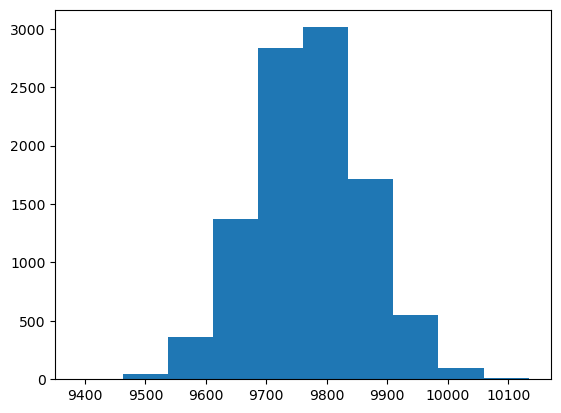

In [25]:
plt.hist(Lscore)

### Emulator uncertainty score

In [26]:
# Emulator prediction of selected sample:
pred = np.empty([np.shape(plausible_sample)[0],npfts,nbiomes])*np.NaN
pred_var = np.empty([np.shape(plausible_sample)[0],npfts,nbiomes])*np.NaN

for p in [1,2,3,4,5,6,7,8,10,11,12,13,14,15]:
    sample = plausible_sample[:,:,p]
    for b in pb_index[pft_names[p]]:  

        loaded_emulator = tf.saved_model.load('/glade/u/home/linnia/clm5ppe/pyth/exp5_pxb/models/pft'+str(p)+'_biome'+str(b))
        y, y_var = loaded_emulator.predict(sample)
        
        pred[:,p,b] = y.numpy().flatten()
        pred_var[:,p,b] = y_var.numpy().flatten()

/glade/derecho/scratch/linnia/tmp/ipykernel_60477/4148027405.py:2: RuntimeWarning: invalid value encountered in multiply
  pred = np.empty([np.shape(plausible_sample)[0],npfts,nbiomes])*np.NaN


In [27]:
# Score emulator uncertainty for each sample
CV_median = np.empty([N,npfts,nbiomes])*np.NaN

for i in range(N):
    ix = draws_ix[i,:].astype('int')

    for p in [1,2,3,4,5,6,7,8,10,11,12,13,14,15]:
        for b in pb_priority[pft_names[p]]: 

            draw_CV = pred_var[ix,p,b]**0.5 / pred[ix,p,b]
            CV_median[i,p,b] = np.median(draw_CV,axis=0)

a = np.nansum(CV_median,axis=2)
Uscore = np.nansum(a,axis=1)

(array([  47.,  422., 1407., 2768., 2735., 1719.,  676.,  184.,   37.,
           5.]),
 array([3.93625054, 4.00608093, 4.07591132, 4.14574171, 4.2155721 ,
        4.28540249, 4.35523288, 4.42506327, 4.49489366, 4.56472405,
        4.63455444]),
 <BarContainer object of 10 artists>)

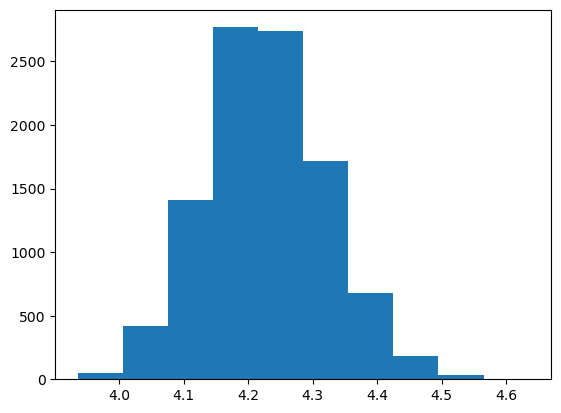

In [28]:
plt.hist(Uscore)

### Select ensemble

In [29]:
ll = np.where(Lscore<np.percentile(L,5))

In [30]:
np.shape(ll)

(1, 494)

In [31]:
uu = np.where(Uscore>np.percentile(Uscore,95))

In [32]:
np.shape(uu)

(1, 500)

In [33]:
ens_id = np.intersect1d(ll,uu)

In [34]:
L = np.array(L)
setid = ens_id[np.argmin(Lscore[ens_id])]
setid

9755

### Plot posteriors

In [35]:
id = setid
#id = ens_id[0]
#id = np.argmin(L)
#id = np.argmax(Uscore)
x1 = plausible_sample[draws_ix[id,:].astype('int'),:,:]

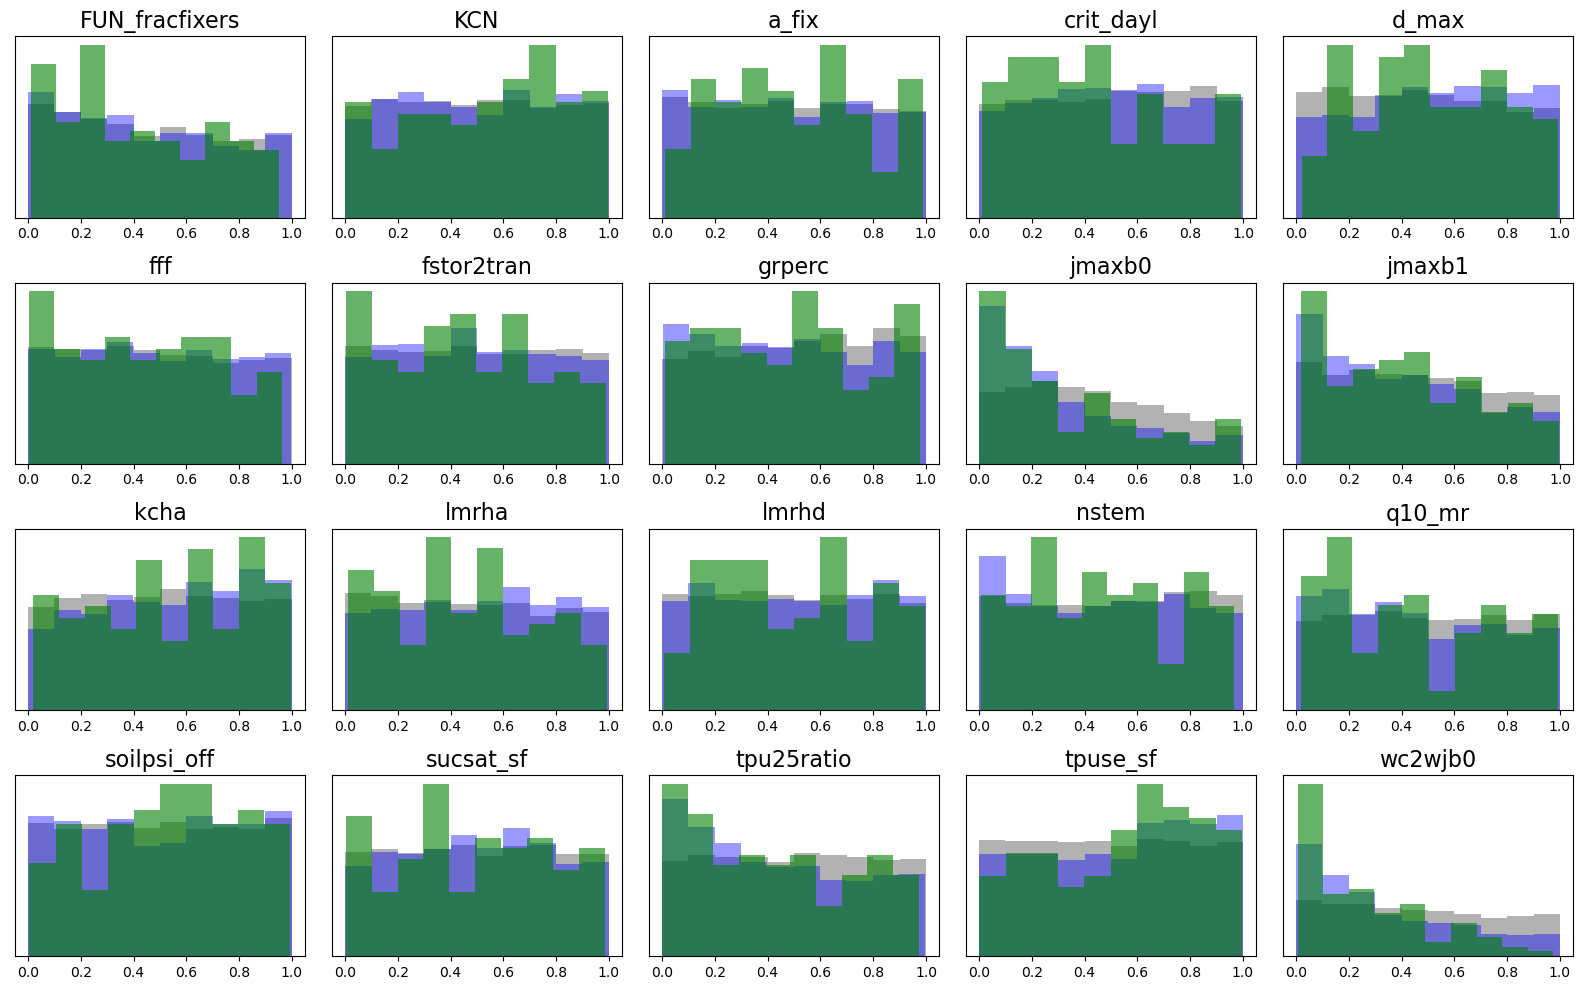

In [36]:
# Universal samples 
plt.figure(figsize=[16,10])
pft = 1
d1 = pd.DataFrame(Psample[:,:,pft],columns = lhc_params.columns)
d2 = pd.DataFrame(plausible_sample[:,:,pft],columns = lhc_params.columns)
d3 = pd.DataFrame(x1[:,:,pft],columns = lhc_params.columns)
for i,param in enumerate(u_params):
    plt.subplot(4,5,i+1)
    plt.hist(d1[param],density=True,color='grey',alpha=0.6)
    plt.hist(d2[param],density=True,color='blue',alpha=0.4)
    plt.hist(d3[param],density=True,color='green',alpha=0.6)
    #plt.xticks([])
    plt.yticks([])
    plt.title(param,fontsize=16)
plt.tight_layout()
#plt.savefig('./figs/posteriors_uparams.png',dpi=200)

theta_cj


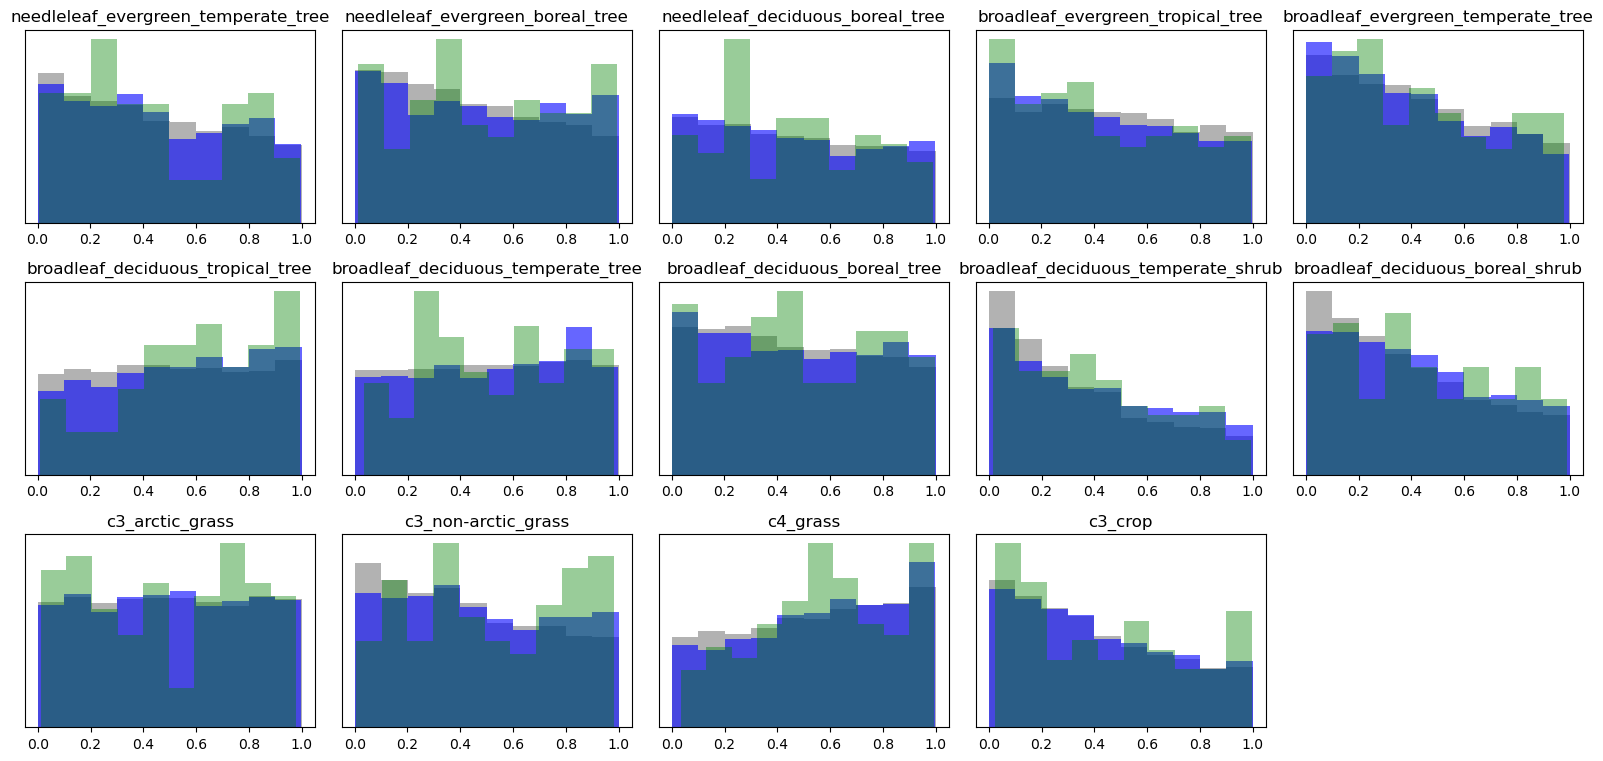

In [51]:
#id = ens_id[0]
#id = np.argmin(L)
#id = np.argmax(Uscore)
#x1 = plausible_sample[draws_ix[id,:].astype('int'),:,:]

pft_params   = ['froot_leaf','kmax','krmax','leaf_long','leafcn','lmr_intercept_atkin',
                'medlynintercept','medlynslope','psi50','slatop','stem_leaf','theta_cj']
pft_param_ix = np.where(pftix)[0]
param = 11
parameter = pft_param_ix[param]
print(pft_params[param])

d1 = Psample[:,parameter,:]
d2 = plausible_sample[:,parameter,:]
d3 = x1[:,parameter,:]

plt.figure(figsize=[16,10])
for i,pft in enumerate(pft_ids):
    plt.subplot(4,5,i+1)
    plt.hist(d1[:,pft],density=True,color='grey',alpha=0.6)
    plt.hist(d2[:,pft],density=True,color='blue',alpha=0.6)
    plt.hist(d3[:,pft],density=True,color='green',alpha=0.4)
    #plt.xticks([])
    plt.yticks([])
    plt.title(pft_names[pft],fontsize=12)
plt.tight_layout()
#plt.savefig('./figs/posteriors_slatop_pfts.png',dpi=200)

### Double check sets

In [139]:
#id = ens_id[0]
#x1 = plausible_sample[draws_ix[id,:].astype('int'),:,:]

In [210]:
np.shape(x1)

(100, 32, 17)

In [52]:
# Emulator prediction of selected sample:
x1_pred = np.empty([n,npfts,nbiomes])*np.NaN
x1_pred_var = np.empty([n,npfts,nbiomes])*np.NaN

for p in [1,2,3,4,5,6,7,8,10,11,12,13,14,15]:
    for b in pb_index[pft_names[p]]:  

        loaded_emulator = tf.saved_model.load('/glade/u/home/linnia/clm5ppe/pyth/wave1/models_lai/pft'+str(p)+'_biome'+str(b))
        y, y_var = loaded_emulator.predict(x1[:,:,p])
        
        x1_pred[:,p,b] = y.numpy().flatten()
        x1_pred_var[:,p,b] = y_var.numpy().flatten()

In [53]:
laimax_pxb = xr.open_dataset("lai_amax_pxb_2003-2007.nc")
laimean_pxb = xr.open_dataset("lai_amean_pxb_2003-2007.nc")
SP_LAI_max = xr.open_dataset("CLM-SP_LAI_pxb_amax_2003-2007.nc")
SP_LAI_mean = xr.open_dataset("CLM-SP_LAI_pxb_amean_2003-2007.nc")
LAI_var = pd.read_csv("LAI_amax_bmean_variance.csv",sep=',')

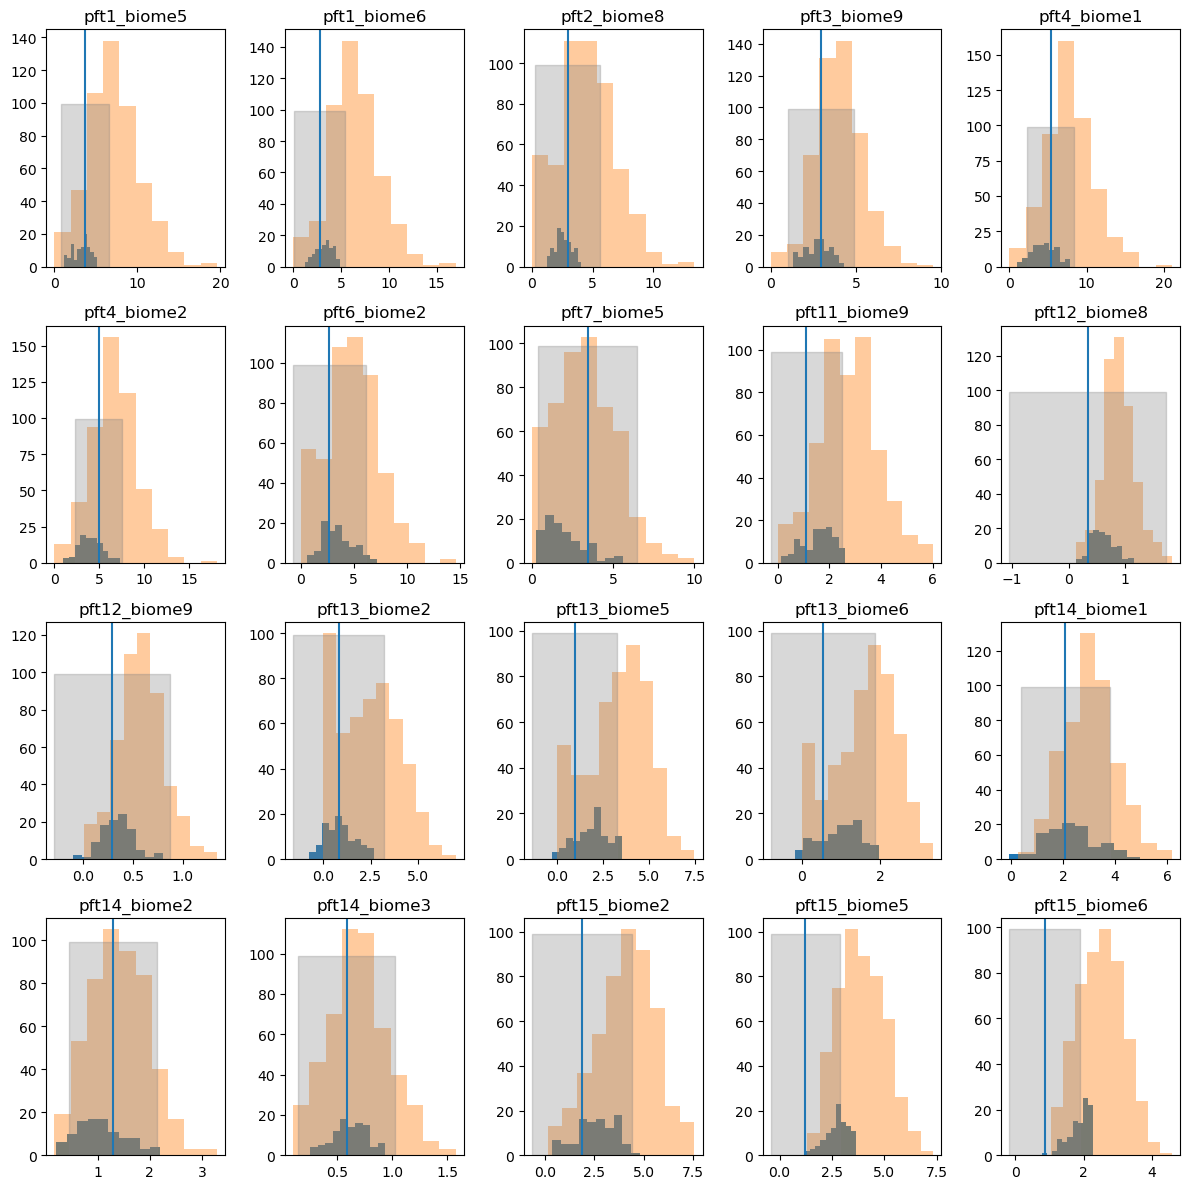

In [55]:
plt.figure(figsize=[12,12])
i = 1
for p in [1,2,3,4,5,6,7,8,10,11,12,13,14,15]:
    for b in pb_priority[pft_names[p]]: 
        pxb = p*10+b
        plt.subplot(4,5,i)
        plt.hist(x1_pred[:,p,b])
        if (p < 12):
            plt.hist(laimax_pxb.TLAI.sel(pxb=pxb).values,alpha=0.4)
            o = SP_LAI_max.TLAI.sel(pxb=pxb).values[0]
            var = LAI_var.TLAI[b]+np.max(x1_pred_var[:,p,b])
            sd3 = 3*(var**0.5)
            plt.axvline(o)
            plt.fill_betweenx(range(100),o-sd3,o+sd3,color='grey',alpha=0.3)
        else:
            plt.hist(laimean_pxb.TLAI.sel(pxb=pxb).values,alpha=0.4)
            o = SP_LAI_mean.TLAI.sel(pxb=pxb).values[0]
            var = LAI_var.TLAI[b]+np.max(x1_pred_var[:,p,b])
            sd3 = 3*(var**0.5)
            plt.axvline(o)
            plt.fill_betweenx(range(100),o-sd3,o+sd3,color='grey',alpha=0.3)
        plt.title('pft'+str(p)+'_biome'+str(b))
        i = i+1
plt.tight_layout()

### Write selected parameter sets

In [90]:
# Replace NaN values with 0.5
nan_indices = np.isnan(x1)
x1[nan_indices] = 0.5

In [91]:
np.shape(x1)

(100, 32, 17)

In [92]:
keys = lhc_params.columns
pset_dict = {}

In [93]:
pft_params   = ['froot_leaf','kmax','krmax','leaf_long','leafcn','lmr_intercept_atkin',
                'medlynslope','medlynintercept','psi50','slatop','stem_leaf','theta_cj']
pftparam_id = [lhc_params.columns.get_loc(col) for col in pft_params]
u_params = lhc_params.columns.difference(pft_params)
uparam_id = [lhc_params.columns.get_loc(col) for col in u_params]

In [94]:
for u in range(len(uparam_id)):
    pset_dict[keys[u]] = x1[:,u,1]
for i,p in enumerate(pft_params):
    pset_dict[p] = x1[:,pftparam_id[i],:]

In [95]:
# ignore some PFT's
extra_pfts = [0,9,16]
for i in range(100):
    pset_dict['medlynintercept'][i][extra_pfts]= 0.08
    pset_dict['theta_cj'][i][extra_pfts]=0.9

In [97]:
pset_dict['froot_leaf'][0:15]

array([[0.5       , 0.39647836, 0.9583803 , 0.41406863, 0.80282907,
        0.3070861 , 0.1891761 , 0.38493937, 0.64331605, 0.5       ,
        0.09599087, 0.63275397, 0.25482134, 0.85609324, 0.29119229,
        0.92966744, 0.5       ],
       [0.5       , 0.35555793, 0.30915222, 0.60338295, 0.18464585,
        0.44996871, 0.81890207, 0.69785471, 0.92100062, 0.5       ,
        0.99234726, 0.93084165, 0.5662903 , 0.12888784, 0.507043  ,
        0.96925436, 0.5       ],
       [0.5       , 0.64748857, 0.29942563, 0.81498443, 0.47091358,
        0.58344675, 0.36623754, 0.97290418, 0.8590598 , 0.5       ,
        0.04133571, 0.9250195 , 0.7027718 , 0.37058442, 0.52557691,
        0.33523146, 0.5       ],
       [0.5       , 0.87711748, 0.10909437, 0.91382314, 0.92843728,
        0.79106074, 0.97659627, 0.72415727, 0.8541686 , 0.5       ,
        0.69890885, 0.8526945 , 0.8526945 , 0.46730583, 0.04781668,
        0.86739083, 0.5       ],
       [0.5       , 0.35429491, 0.94277676, 0.752350

In [98]:
np.save('Wave1_psets_2-21.npy', pset_dict)